# Build the final dataset for modelling

In [406]:
# Lienar Return
# NO mean scaling
# Standard scaling
# Only Option Prices in VIX


import pandas as pd
import numpy as np
import sklearn.preprocessing as pre
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
from main import interpolateZCR
import scipy.stats as stat
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import arma_order_select_ic

In [407]:
#Import Datasets
call30 = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/New Interpolation/call30TimeInt_missing.csv')
put30  = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/New Interpolation/put30TimeInt_missing.csv')
zcr = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/ZCR.csv') 
zcr = zcr.pivot('date','days','rate')
priceSPX = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/PriceSPX.csv')
priceSPX = priceSPX[['date','close']]
realVol = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/Realized_Vol.csv')
CBOE = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/VIX.csv')
CBOE['date']=pd.to_datetime(CBOE.Date,infer_datetime_format=True).dt.strftime('%Y%m%d').astype(int)
realVol = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/Realized_Vol.csv')

In [408]:
#Reallign OTM_K  based on the VIX White Paper Documentation --> the ATM is the Strike Ki which minimize the [C(Ki) - P(Ki)] not the closest to the spot price
call30 = call30[['date','cp_flag','strike_price','expT','mid_price','close','OTM_K']]
put30 = put30[['date','cp_flag','strike_price','expT','mid_price','close','OTM_K']]
alloption = pd.merge(call30,put30,on=['date','strike_price'])
alloption['difference'] = abs(alloption['mid_price_x'] - alloption['mid_price_y'])
alloption['difference1'] =alloption['mid_price_x'] - alloption['mid_price_y']
alloption1 =alloption.pivot('date','OTM_K_x','difference1')
alloption = alloption.pivot('date','OTM_K_x','difference')
alloption['difference'] = alloption.min(axis=1)
alloption['ATM'] = alloption.idxmin(axis=1)
difference = alloption[['difference','ATM']].copy()

for k in difference.index:
    difference.at[k,'difference'] = alloption1.at[k,difference.at[k,'ATM']]

In [409]:
#Reallign OTM_K  based on the VIX White Paper Documentation and the above calculation
call30 = pd.merge(call30,difference,on='date')
call30['OTM_K'] = call30['OTM_K'] - call30['ATM']
call30['ATM'] = call30['strike_price'] - call30['OTM_K']
put30 = pd.merge(put30,difference,on='date')
put30['OTM_K'] = put30['OTM_K'] + put30['ATM']
put30['ATM'] = put30['strike_price'] + put30['OTM_K']

## Options Price Surface 

In [410]:
#Change sign for put OTM_K
put30.loc[:,'OTM_K'] = -put30.OTM_K
#Filter out unecessary OTM_K. Note that the ATM (OTM_K = 0) option will always be a PUT
call30 = call30[(call30.OTM_K>=5) & (call30.OTM_K<=200)]
put30  = put30[(put30.OTM_K>=-200) & (put30.OTM_K<=0)]
#Merge put and call
surface = call30.append(put30).copy()
surface = surface.pivot(index='date',columns='OTM_K',values='mid_price').copy()
#Assign Zero to negative prices
surface[surface<=0] = 0

#surface.interpolate(method='linear',inplace=True)
#surface.dropna(inplace=True)
surface.fillna(0,inplace=True)

In [411]:
#CHECK FOR NaN Values
surface[surface.isna().any(axis=1)]

OTM_K,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,-155.0,...,155.0,160.0,165.0,170.0,175.0,180.0,185.0,190.0,195.0,200.0
date,,,,,,,,,,,,,,,,,,,,,


In [412]:
surface[100]

date
19960104    0.000000
19960105    0.000000
19960108    0.000000
19960109    0.000000
19960110    0.000000
              ...   
20171222    0.366667
20171226    0.450000
20171227    0.450000
20171228    0.366667
20171229    0.350000
Name: 100.0, Length: 5369, dtype: float64

## Calculate VIX

### In order to compute the VIX, besides the OTM options we also need the Forward SPX price and the zero-coupon rate 30 days. 

In [413]:
#Interpolate the zero coupon curve at maturity 30 days
zcr = interpolateZCR(zcr,30)
zcr = zcr[[30]]/100
zcr.rename(columns={30:'zcr'},inplace=True)

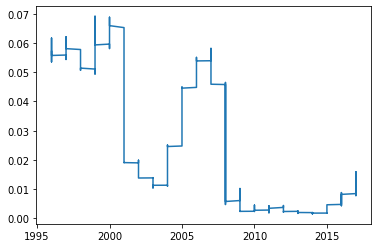

In [414]:
plt.plot(np.round(zcr.index/10000),zcr)

In [415]:
#Merge the dataset
surface = pd.merge(surface,zcr,on='date')

surface = pd.merge(surface,difference[['difference']], left_on='date',right_index=True)

surface = pd.merge(surface,call30[['date','ATM']].drop_duplicates(), on='date')

surface.rename(columns={'rate':'div_yield'},inplace=True)

In [416]:
#Compute the Forward SPX price based on VIX whitepaper
surface['F'] = np.add(surface['ATM'], np.multiply(surface['difference'], np.exp(surface['zcr']*30/365) ))

**STANDARDIZATION ON K^2**

In [417]:
#Column by column

for k in range(1,82,1):
    surface.iloc[:,k] = np.divide(  surface.iloc[:,k].values, np.power(surface.loc[:,'ATM'].values - 200 +(k-1)*5,2 )   )
    

In [418]:
#Compute VIX NOT ANNUALIZED --> horizon 30days 
def vix(surface,num=[20,40,60,80]):
    for num in num: 
        name = 'vix'+str(num)
        for k in surface.index:
            i = surface.at[k,'date']
            range_k = np.array(range(-int(num/2*5),(int(num/2+1)*5),5)) + surface[surface.date==i]['ATM'].values
            weights = np.power(range_k,0)*5*2/(30/365) #* np.exp(surface[surface.date==i]['zcr'].values*30/365)
            options = surface[surface.date==i][range(-int(num/2*5),(int(num/2+1)*5),5)].values
            lhs = np.multiply(weights,options).sum()
            rhs = 0#365/30*((surface[surface.date==i]['F'].values/surface[surface.date==i]['ATM'].values)-1)**2
            vix = ((lhs-rhs))*30/365    #if we eliminate the term 30/365 we obtain the annualized VIX
            surface.at[k,name] = vix
    return surface 

In [419]:
#Compute VIX* and Merge with original VIX data
surface = vix(surface)
surface = pd.merge(surface, CBOE[['date','vix']],on='date')
surface.vix = np.power(surface.vix/100,2)*30/365
surface.vix.fillna(method='pad',limit=2,inplace=True)
#Check for NaN values
surface[surface.vix.isna()]

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,200.0,zcr,difference,ATM,F,vix20,vix40,vix60,vix80,vix


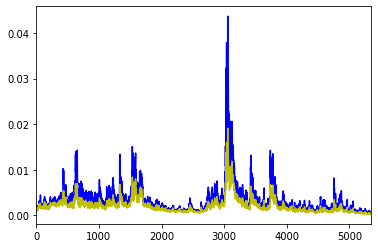

In [420]:
#plt.plot(surface.vix, color='k')
surface.vix80.plot(color='b')
#surface.vix60.plot(color='g')
#surface.vix40.plot(color='r')
surface.vix20.plot(color='y')

### Import Realized Variance

**FROM OPTIONMETRICS**

Methodology: Realized volatility is calculated over date ranges of  30 and 60 calendar days, using a simple standard deviation calculation on the logarithm of the close-to-close daily total return.

In [421]:
try:
    realVol.drop(columns=['secid','index_flag'], inplace=True)
except:
    print('Already dropped')

In [422]:
'''PREPARE Realized Variance AND SHIFT DATA'''
realVol30  = realVol[realVol['days']==30 ].drop(columns='days').copy()
realVol30.rename(columns={'volatility':'realVol30'},inplace=True)
realVol30.index = pd.to_datetime(realVol30.date,format='%Y%m%d')
realVol30.index.names = ['index']
#Shift based on index
realVol30['realVol30_baselag'] = realVol30[['realVol30']].shift(-25)
#Shift based on correct number of daycount --> These are the correct data 
realVol30['realVol30_lagged'] = realVol30[['realVol30']].shift(-30,freq='d')
#Pad the correct day-shift column with index-shift column for any missing values. 
#This procedure guarantees a good balance between correctness of the shift and data destruction
#Since day-shift has problems with weekend days (no data) and returns only 3 obs per week. 
#NOTE that overall the two procedure yield results that are almost perfectly alligned with 1-day of difference at most
realVol30[['realVol30_baselag','realVol30_lagged']] = realVol30[['realVol30_baselag','realVol30_lagged']].fillna(method='pad',axis=1)

In [423]:
realVol60  = realVol[realVol['days']==60 ].drop(columns='days').copy()
realVol60.rename(columns={'volatility':'realVol60'},inplace=True)
realVol60.index = pd.to_datetime(realVol60.date,format='%Y%m%d')
realVol60.index.names = ['index']
realVol60['realVol60_baselag'] = realVol60[['realVol60']].shift(-21)
#Shift based on correct number of daycount --> These are the correct data 
realVol60['realVol60_lagged'] = realVol60[['realVol60']].shift(-60,freq='d')
#Pad the correct day-shift column with index-shift column for any missing values. 
#This procedure guarantees a good balance between correctness of the shift and data destruction
#Since day-shift has problems with weekend days (no data) and return only 3 obs per week. 
#NOTE that overall the two procedure yield results that are almost perfectly alligned with 1-day of difference at most
realVol60[['realVol60_baselag','realVol60_lagged']] = realVol60[['realVol60_baselag','realVol60_lagged']].fillna(method='pad',axis=1)

### Calculate Realized Returns

In [424]:
#Compute Linear Return
priceSPX['ret'] = priceSPX['close']/priceSPX['close'].shift(1) -1 #np.log(priceSPX['close']/priceSPX['close'].shift(1))
priceSPX['var30'] = priceSPX['ret'].rolling(30).var() *30   #Variance over 30days --> NO ANNUALIZATION
priceSPX['var60'] = priceSPX['ret'].rolling(60).var() *30 #Variance over 60days --> NO ANNUALIZATION
priceSPX['var30'] = priceSPX['var30'].shift(-30)
priceSPX['var60'] = priceSPX['var30'].shift(-60)

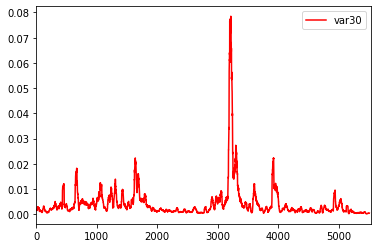

In [425]:
priceSPX.var30.plot(legend='y', color='r')

In [426]:
priceSPX[-40:]

,date,close,ret,var30,var60
5499,20171102,2579.85,0.000190,0.000492,NaN
5500,20171103,2587.84,0.003097,0.000506,NaN
5501,20171106,2591.13,0.001271,0.000527,NaN
5502,20171107,2590.64,-0.000189,0.000529,NaN
5503,20171108,2594.38,0.001444,0.000529,NaN
5504,20171109,2584.62,-0.003762,0.000507,NaN
5505,20171110,2582.30,-0.000898,0.000508,NaN
5506,20171113,2584.84,0.000984,0.000508,NaN
5507,20171114,2578.87,-0.002310,0.000494,NaN
5508,20171115,2564.62,-0.005526,0.000490,NaN


### Merge Datasets

In [427]:
surface = pd.merge(surface,realVol30[['date','realVol30','realVol30_lagged','realVol30_baselag']],on='date')
surface = pd.merge(surface, priceSPX[['date','var30']], on='date')
#surface = pd.merge(surface,realVol60,on='date')

In [428]:
#Compute Monthly Variance from Annualised OptionMetrics Data using the convention 30/252 assumed by OptionMetrics.
surface.realVol30 = np.power(surface.realVol30,2)*30/365
surface.realVol30_lagged = np.power(surface.realVol30_lagged,2)*30/365
surface.realVol30_baselag = np.power(surface.realVol30_baselag,2)*30/365
#surface.realVol60 = np.power(surface.realVol60,2)

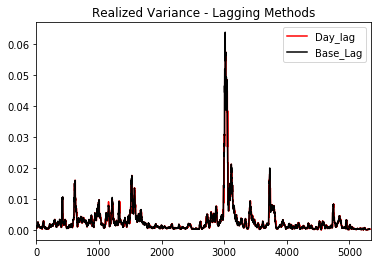

In [429]:
surface.realVol30_lagged.plot(color='r')
surface.realVol30_baselag.plot(color='k')
plt.title('Realized Variance - Lagging Methods')
plt.legend(['Day_lag','Base_Lag'])

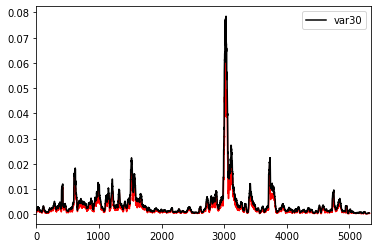

In [430]:
surface.realVol30_baselag.plot(color='r')
surface.var30.plot(legend='y', color='k')


#surface.realVol30_lagged.plot(color='g')

In [431]:
surface.index = pd.to_datetime(surface.date,format='%Y%m%d')
surface.index.names = ['index']

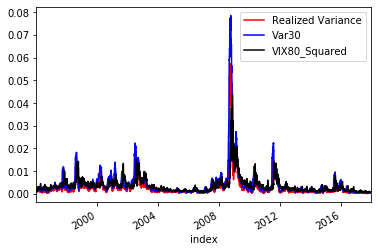

In [432]:
plt.plot(surface.realVol30_lagged,color='r')
surface.var30.plot(color='b')
surface.vix80.plot(color='k')
plt.legend(['Realized Variance','Var30','VIX80_Squared'])

In [433]:
#CHECK FOR NaN Values
surface[surface.isna().any(axis=1)].head()

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,F,vix20,vix40,vix60,vix80,vix,realVol30,realVol30_lagged,realVol30_baselag,var30
index,,,,,,,,,,,,,,,,,,,,,
2017-11-16,20171116,6.353978e-07,6.477478e-07,6.848944e-07,6.886574e-07,7.323126e-07,7.403454e-07,7.687175e-07,7.996949e-07,8.304106e-07,...,2584.332621,0.000471,0.000660,0.000775,0.000853,0.001137,0.000270,0.000339,0.000339,NaN
2017-11-17,20171117,5.678742e-07,6.014932e-07,6.098166e-07,6.388197e-07,6.452546e-07,6.878552e-07,6.858238e-07,7.172791e-07,7.427771e-07,...,2578.097962,0.000438,0.000607,0.000709,0.000779,0.001074,0.000279,0.000345,0.000345,NaN
2017-11-20,20171120,4.369395e-07,4.727812e-07,4.726808e-07,5.118029e-07,5.078125e-07,5.532480e-07,5.509547e-07,5.658218e-07,5.976368e-07,...,2581.601726,0.000425,0.000577,0.000664,0.000720,0.000932,0.000270,0.000365,0.000342,NaN
2017-11-21,20171121,3.515625e-07,3.692436e-07,3.787814e-07,3.900741e-07,4.055392e-07,4.208736e-07,4.360785e-07,4.511551e-07,4.724033e-07,...,2598.348196,0.000362,0.000490,0.000561,0.000606,0.000778,0.000295,0.000340,0.000268,NaN
2017-11-22,20171122,3.573904e-07,3.689236e-07,3.760357e-07,3.916944e-07,4.029337e-07,4.140769e-07,4.293761e-07,4.487798e-07,4.595879e-07,...,2596.501656,0.000376,0.000503,0.000572,0.000618,0.000802,0.000277,0.000339,0.000305,NaN


In [434]:
surface.tail()

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,F,vix20,vix40,vix60,vix80,vix,realVol30,realVol30_lagged,realVol30_baselag,var30
index,,,,,,,,,,,,,,,,,,,,,
2017-12-22,20171222,4.180040e-07,4.463551e-07,4.480000e-07,4.735325e-07,4.748602e-07,4.848312e-07,5.052175e-07,5.189034e-07,5.363829e-07,...,2688.715002,0.000356,0.000478,0.000550,0.000600,0.000806,0.000339,NaN,NaN,NaN
2017-12-26,20171226,4.516056e-07,4.675827e-07,4.740000e-07,4.980060e-07,5.158648e-07,5.266611e-07,5.472096e-07,5.685717e-07,5.858551e-07,...,2687.947325,0.000391,0.000530,0.000610,0.000664,0.000864,0.000345,NaN,NaN,NaN
2017-12-27,20171227,5.343935e-07,5.483783e-07,5.622467e-07,5.760000e-07,5.896391e-07,6.190378e-07,6.323886e-07,6.613757e-07,6.744437e-07,...,2686.101426,0.000402,0.000549,0.000639,0.000702,0.000901,0.000342,NaN,NaN,NaN
2017-12-28,20171228,4.556378e-07,4.787129e-07,4.813333e-07,5.067709e-07,5.158648e-07,5.438542e-07,5.485219e-07,5.672646e-07,5.884589e-07,...,2689.098836,0.000360,0.000490,0.000569,0.000623,0.000852,0.000268,NaN,NaN,NaN
2017-12-29,20171229,4.877732e-07,5.157707e-07,5.120885e-07,5.397569e-07,5.520000e-07,5.784838e-07,5.793559e-07,6.118359e-07,6.193836e-07,...,2679.215654,0.000372,0.000507,0.000588,0.000646,0.001002,0.000305,NaN,NaN,NaN


**DROP THE NaN ROW DUE TO RealVol Lagging**

In [435]:
surface.dropna(inplace=True)

In [436]:
surface[surface.isna().any(axis=1)]

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,F,vix20,vix40,vix60,vix80,vix,realVol30,realVol30_lagged,realVol30_baselag,var30
index,,,,,,,,,,,,,,,,,,,,,


### Imputation of missing values


**ROBUST SCALING OF FEATURES**

**STANDARD SCALING**

In [437]:
surface.iloc[:,range(1,82,1)] = pre.scale(surface.iloc[:,range(1,82,1)],copy=False, with_mean=False)

In [438]:
surface.iloc[:,range(1,82,1)]

,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,-155.0,...,155.0,160.0,165.0,170.0,175.0,180.0,185.0,190.0,195.0,200.0
index,,,,,,,,,,,,,,,,,,,,,
1996-01-04,0.136285,0.137428,0.142533,0.146466,0.149452,0.152037,0.153396,0.154342,0.154744,0.154843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-05,0.149338,0.150921,0.156802,0.161357,0.164838,0.167850,0.169486,0.170647,0.171189,0.171381,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-08,0.126334,0.126139,0.129760,0.132430,0.134343,0.135980,0.136595,0.136910,0.136799,0.136471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-09,0.000000,0.119822,0.134540,0.147015,0.157548,0.166817,0.174007,0.180076,0.184944,0.188957,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-10,0.172911,0.196304,0.222135,0.244068,0.262620,0.278939,0.291675,0.302442,0.311116,0.318288,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09,0.202867,0.187733,0.195715,0.187120,0.196138,0.188586,0.195187,0.186414,0.189533,0.188161,...,0.052698,0.057055,0.044368,0.055369,0.059999,0.061911,0.059958,0.054607,0.058719,0.064102
2017-11-10,0.221954,0.228170,0.215309,0.228243,0.214326,0.229455,0.212976,0.230103,0.215751,0.215928,...,0.048716,0.050392,0.046465,0.042513,0.046397,0.052657,0.054498,0.044503,0.036668,0.052707
2017-11-13,0.246875,0.232928,0.238199,0.230959,0.240995,0.234005,0.241041,0.234609,0.235824,0.236881,...,0.046458,0.050969,0.046297,0.049923,0.052130,0.045121,0.048645,0.051733,0.053500,0.054062


In [439]:
surface[surface[5]==0]

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,F,vix20,vix40,vix60,vix80,vix,realVol30,realVol30_lagged,realVol30_baselag,var30
index,,,,,,,,,,,,,,,,,,,,,
1997-03-20,19970320,0.000000,0.328634,0.339367,0.347769,0.354303,0.339864,0.324927,0.311116,0.297943,...,783.076690,0.002605,0.003138,0.003327,0.003415,0.003701,0.001457,0.003076,0.003076,0.004437
1997-03-31,19970331,0.000000,1.184691,1.157458,1.128659,1.099463,1.073175,1.043359,1.015286,0.987575,...,754.981248,0.002751,0.003327,0.003683,0.003963,0.004029,0.002103,0.002809,0.003213,0.004108
1997-08-28,19970828,0.279384,0.292814,0.313725,0.331556,0.346774,0.355632,0.382621,0.406635,0.427494,...,901.350105,0.003081,0.003957,0.004257,0.004380,0.004938,0.002469,0.001660,0.001660,0.003005
1997-10-07,19971007,0.000000,0.285831,0.292193,0.296988,0.300568,0.346500,0.386321,0.422066,0.453640,...,984.506741,0.002081,0.002665,0.002866,0.002963,0.003384,0.001746,0.009773,0.009845,0.011423
1997-10-30,19971030,2.971011,3.024045,3.165308,3.282152,3.378895,3.467410,3.528481,3.580239,3.619360,...,901.852462,0.005269,0.007761,0.009278,0.010251,0.011994,0.009210,0.002518,0.002518,0.003736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-21,20100421,0.000000,0.332546,0.335936,0.337976,0.339037,0.340207,0.344031,0.347292,0.349625,...,1203.382639,0.001257,0.001588,0.001747,0.001837,0.002189,0.000788,0.007247,0.007132,0.010299
2010-07-20,20100720,0.507694,0.000000,0.549935,0.574148,0.594726,0.613751,0.612751,0.611381,0.608940,...,1081.741530,0.002561,0.003491,0.003851,0.004007,0.004707,0.004187,0.002797,0.002221,0.003729
2010-10-18,20101018,0.313549,0.000000,0.328682,0.339009,0.347605,0.355650,0.365885,0.374959,0.382532,...,1182.446416,0.001673,0.002215,0.002417,0.002510,0.002995,0.001450,0.001339,0.001261,0.002196


(array([3.517e+03, 8.790e+02, 4.270e+02, 2.050e+02, 7.100e+01, 4.200e+01,
        2.500e+01, 2.100e+01, 1.900e+01, 7.000e+00, 1.300e+01, 7.000e+00,
        1.100e+01, 4.000e+00, 3.000e+00, 8.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

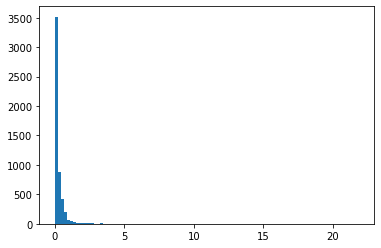

In [440]:
plt.hist(surface[200], bins=100)

### Compute regression_2 target variable.

In [441]:
'''
    Note that VRP = VIX* - Realized Variance. 
    In our case we compute the opposite sign quantity and call it Negative VRP since its more practical for regression purposes. 
    Therefore we use a PROXY of VRP, which is the VRP*-1
    NegVRP = realVol30_lagged - VIX*

'''

surface['negVRP20'] = surface['realVol30_lagged'].values - surface['vix20'].values
surface['negVRP40'] = surface['realVol30_lagged'].values - surface['vix40'].values
surface['negVRP60'] = surface['realVol30_lagged'].values - surface['vix60'].values
surface['negVRP80'] = surface['realVol30_lagged'].values - surface['vix80'].values
surface.head()

,date,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,...,vix80,vix,realVol30,realVol30_lagged,realVol30_baselag,var30,negVRP20,negVRP40,negVRP60,negVRP80
index,,,,,,,,,,,,,,,,,,,,,
1996-01-04,19960104,0.136285,0.137428,0.142533,0.146466,0.149452,0.152037,0.153396,0.154342,0.154744,...,0.001518,0.001561,0.000816,0.001088,0.001088,0.001696,-0.000215,-0.000327,-0.000387,-0.000430
1996-01-05,19960105,0.149338,0.150921,0.156802,0.161357,0.164838,0.167850,0.169486,0.170647,0.171189,...,0.001415,0.001516,0.000799,0.000624,0.000624,0.001733,-0.000564,-0.000677,-0.000744,-0.000791
1996-01-08,19960108,0.126334,0.126139,0.129760,0.132430,0.134343,0.135980,0.136595,0.136910,0.136799,...,0.001316,0.001413,0.000801,0.001346,0.000625,0.001899,0.000227,0.000120,0.000068,0.000030
1996-01-09,19960109,0.000000,0.119822,0.134540,0.147015,0.157548,0.166817,0.174007,0.180076,0.184944,...,0.001969,0.001901,0.000984,0.001088,0.000628,0.001731,-0.000624,-0.000759,-0.000838,-0.000881
1996-01-10,19960110,0.172911,0.196304,0.222135,0.244068,0.262620,0.278939,0.291675,0.302442,0.311116,...,0.002143,0.002211,0.001276,0.000624,0.000707,0.001490,-0.001104,-0.001309,-0.001443,-0.001519


### SAVE DATASET

In [442]:
surface.to_csv('/home/student/surface/Realized Variance/DatasetSPX/Dataset30.csv')

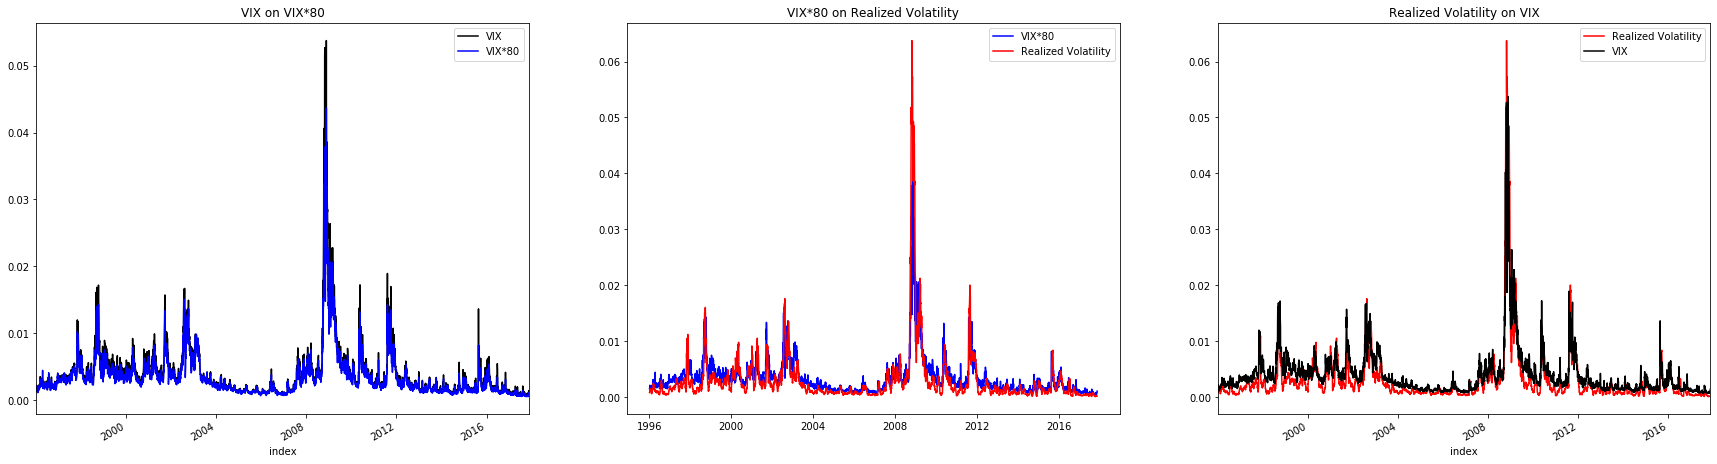

In [443]:
dif = surface.vix80 - surface.realVol30_lagged

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
surface.vix.plot(color='k')
plt.plot(surface.vix80,color='b')
plt.title('VIX on VIX*80')
plt.legend(['VIX','VIX*80'])
plt.subplot(1,3,2)
plt.plot(surface.vix80,color='b')
plt.plot(surface.realVol30, color='r')
plt.title('VIX*80 on Realized Volatility')
plt.legend(['VIX*80','Realized Volatility'])
plt.subplot(1,3,3)
plt.plot(surface.realVol30, color='r')
surface.vix.plot(color='k')
plt.title('Realized Volatility on VIX')
plt.legend(['Realized Volatility','VIX'])


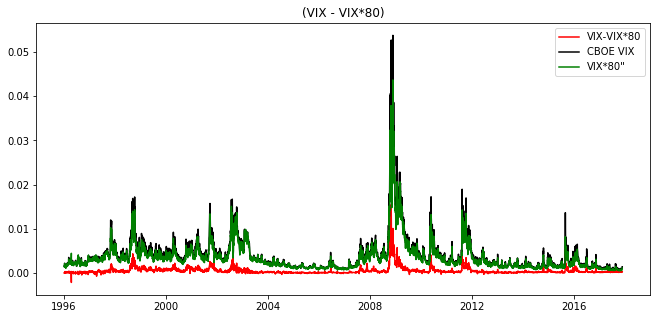

In [444]:
#Difference between CBOE-VIX and VIX* replicated by our methodology
plt.figure(figsize=(11,5))
plt.plot(surface.vix - surface.vix80,color='r')
plt.title('(VIX - VIX*80)')
plt.plot(surface.vix,color='k')
plt.plot(surface.vix80,color='g')
plt.legend(['VIX-VIX*80','CBOE VIX','VIX*80"'])

In [445]:
stat.pearsonr(surface.vix,surface.vix80)

(0.994192096747915, 0.0)

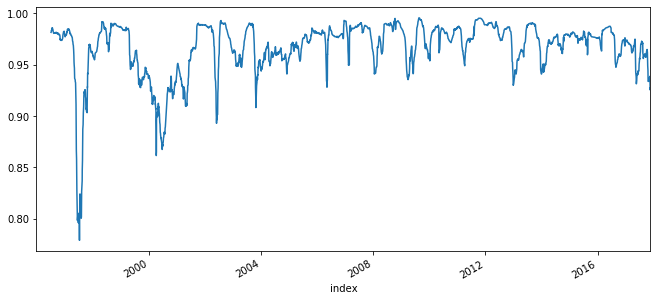

In [446]:
plt.figure(figsize=(11,5))
surface.vix.rolling(125).corr(surface.vix20).plot()
plt.show()

The Uncoditional Average Variance Risk Premium is 0.00047587066605744844


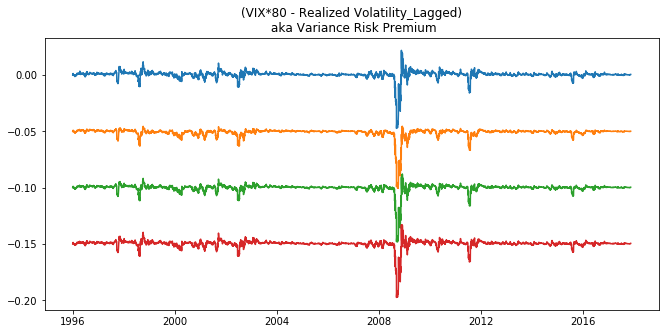

In [447]:
#Analyzing Variance Risk Premiuim
plt.figure(figsize=(11,5))
plt.plot(dif)
plt.plot(surface.vix20-surface.realVol30_lagged-0.05)
plt.plot(surface.vix40-surface.realVol30_lagged-0.1)
plt.plot(surface.vix60-surface.realVol30_lagged-0.15)
plt.title('(VIX*80 - Realized Volatility_Lagged)\n aka Variance Risk Premium')
print('The Uncoditional Average Variance Risk Premium is ' +str(dif.mean()))

In [448]:
r2(surface.realVol30_lagged,surface.vix80)

0.43739758960543174

**Testing for Stationarity and Unit Roots in Variance Risk Premium**

In [449]:
# H0: time-series is stationary 
# H1: time-series is not stationary
kpss_test = tsa.stattools.kpss(dif.dropna(),lags='auto')
print('KPSS stat is '+str(kpss_test[0])[:5] + '.\nThe 10% threshold is ' + str(kpss_test[3]['10%']) +'. \nThe null hypotesys cannot be rejected at 10% confidence level.\nP-value is >' + str(kpss_test[1]) +'\n\n\n' )

KPSS stat is 0.163.
The 10% threshold is 0.347. 
The null hypotesys cannot be rejected at 10% confidence level.
P-value is >0.1





/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [450]:
# Ho: time-series has unit root
# H0: time-series has  NO unit root
adf_test = tsa.stattools.adfuller(dif.dropna(),autolag='BIC')
print('ADF stat is '+str(adf_test[0])[:5] + '.\nThe 1% threshold is ' + str(adf_test[4]['1%']) +'. \nThe null hypotesys is rejected at 1% confidence level.\nP-value is: ' + str(adf_test[1])) 

ADF stat is -9.35.
The 1% threshold is -3.431586762948091. 
The null hypotesys is rejected at 1% confidence level.
P-value is: 7.88382153580599e-16


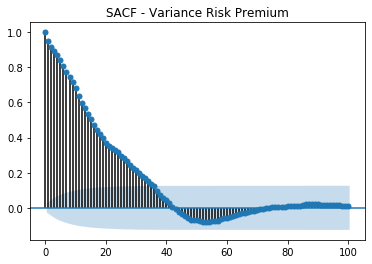

In [451]:
acf = plot_acf(dif.dropna(),lags=100)
plt.title('SACF - Variance Risk Premium')
plt.show()

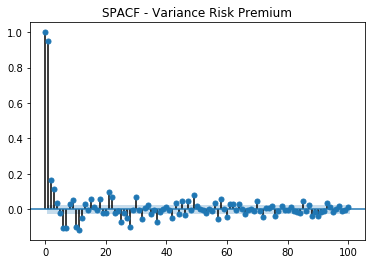

In [452]:
plot_pacf(dif.dropna(), lags=100)
plt.title('SPACF - Variance Risk Premium')
plt.show()

In [453]:
dif.describe()

count    5320.000000
mean        0.000476
std         0.003882
min        -0.047243
25%         0.000181
50%         0.000774
75%         0.001606
max         0.022083
dtype: float64

In [454]:
acorr_ljungbox((surface.vix-surface.vix80),lags=5,boxpierce=True)

(array([ 4523.36517805,  8646.96103866, 12443.04063035, 16050.79995661,
        19608.70188771]),
 array([0., 0., 0., 0., 0.]),
 array([ 4520.81536679,  8641.31194453, 12433.825133  , 16037.51708684,
        19590.73932732]),
 array([0., 0., 0., 0., 0.]))

### Features Exploration

/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


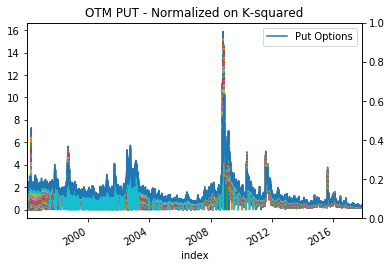

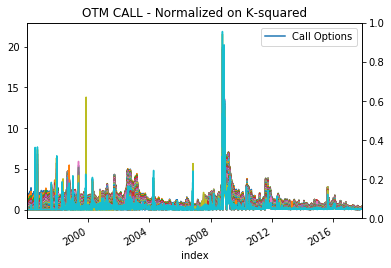

In [455]:

surface[range(-200,5,5)].plot()
plt.title('OTM PUT - Normalized on K-squared')
plt.legend(['Put Options'])
plt.twinx()
#surface['realVol30_lagged'].plot(color='k')
#plt.legend(['Realized Variance'])

surface[range(5,205,5)].plot()
plt.title('OTM CALL - Normalized on K-squared')
plt.legend(['Call Options'])
plt.twinx()
#surface['realVol30_lagged'].plot(color='k')
#plt.legend(['Realized Variance'])
plt.show()

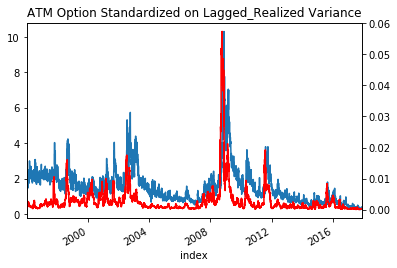

In [456]:

surface[0].plot()
plt.title('ATM Option Standardized on Lagged_Realized Variance')
plt.twinx()
surface['realVol30_lagged'].plot(color='r')

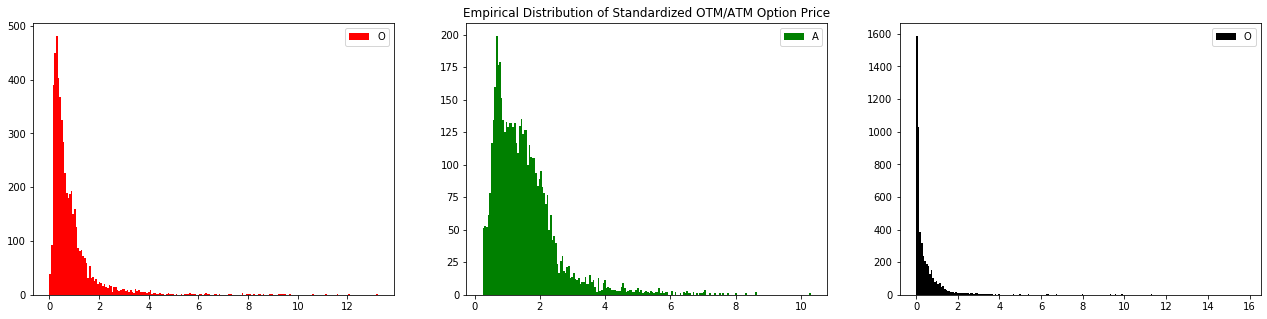

In [457]:
#Distribution of the Standardized ATM Option
plt.figure(figsize=(22,5))
plt.subplot(1,3,1)
plt.hist(surface[-100], bins=200,color='r')
plt.legend('OTM Put')
plt.subplot(1,3,2)
plt.title('Empirical Distribution of Standardized OTM/ATM Option Price')
plt.hist(surface[0], bins=200,color='g')
plt.legend('ATM Put')
plt.subplot(1,3,3)
plt.hist(surface[100], bins=200,color='k')
plt.legend('OTM Call')
plt.show()

In [458]:
surface[range(-200,205,5)]

,-200.0,-195.0,-190.0,-185.0,-180.0,-175.0,-170.0,-165.0,-160.0,-155.0,...,155.0,160.0,165.0,170.0,175.0,180.0,185.0,190.0,195.0,200.0
index,,,,,,,,,,,,,,,,,,,,,
1996-01-04,0.136285,0.137428,0.142533,0.146466,0.149452,0.152037,0.153396,0.154342,0.154744,0.154843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-05,0.149338,0.150921,0.156802,0.161357,0.164838,0.167850,0.169486,0.170647,0.171189,0.171381,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-08,0.126334,0.126139,0.129760,0.132430,0.134343,0.135980,0.136595,0.136910,0.136799,0.136471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-09,0.000000,0.119822,0.134540,0.147015,0.157548,0.166817,0.174007,0.180076,0.184944,0.188957,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-10,0.172911,0.196304,0.222135,0.244068,0.262620,0.278939,0.291675,0.302442,0.311116,0.318288,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09,0.202867,0.187733,0.195715,0.187120,0.196138,0.188586,0.195187,0.186414,0.189533,0.188161,...,0.052698,0.057055,0.044368,0.055369,0.059999,0.061911,0.059958,0.054607,0.058719,0.064102
2017-11-10,0.221954,0.228170,0.215309,0.228243,0.214326,0.229455,0.212976,0.230103,0.215751,0.215928,...,0.048716,0.050392,0.046465,0.042513,0.046397,0.052657,0.054498,0.044503,0.036668,0.052707
2017-11-13,0.246875,0.232928,0.238199,0.230959,0.240995,0.234005,0.241041,0.234609,0.235824,0.236881,...,0.046458,0.050969,0.046297,0.049923,0.052130,0.045121,0.048645,0.051733,0.053500,0.054062
